In [1]:
import os
import sys
sys.path.append(os.path.join(os.path.dirname('__file__'), "../"))


import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook as tqdm

warnings.filterwarnings('ignore')


sns.set(style='white', context='notebook', palette='deep')
%matplotlib inline

In [2]:
def visualize_feature_importance(model, X_train):
    # barplotに持ち込むためのDFを生成
    df = pd.DataFrame()
    df['feature_name'] = X_train.columns
    df['feature_importance'] = model.feature_importances_

    # 降順のほうが見やすいのでソート
    df.sort_values(by='feature_importance', ascending=False, inplace=True)

    # 重要度0はノイズに思えるので除外している
    df = df[df['feature_importance'] > 0]

    sns.barplot(x='feature_importance',
                y='feature_name',
                data=df)

    plt.xlim(0, 1.0)

# 特徴量のロード(便利だ)

In [8]:
from features.base import BaseFeature, FeatureLoader

features = ['Title', 'FilledAgeCategoryFromTitle', 'FamilySizeCategory']

X_train, X_test = FeatureLoader(features).load()

train = pd.read_csv('../input_data/train.csv')
test = pd.read_csv('../input_data/test.csv')

train = pd.concat([train, X_train], axis=1)
test = pd.concat([test, X_test], axis=1)

train = train[['Survived', 'Title', 'FilledAgeCategoryFromTitle', 'FamilySizeCategory']]

test = test[['Title', 'FilledAgeCategoryFromTitle', 'FamilySizeCategory']]

In [9]:
train.head()

,Survived,Title,FilledAgeCategoryFromTitle,FamilySizeCategory
0,0,Mr,20代,IsMedium
1,1,Mrs,30代,IsMedium
2,1,Miss,20代,IsAlone
3,1,Mrs,30代,IsMedium
4,0,Mr,30代,IsAlone


# GridSearchCVで予測モデルつくる

In [10]:
from sklearn.model_selection import train_test_split

X_train = pd.get_dummies(train, drop_first=True).drop(columns=['Survived'])
y_train = train['Survived']

In [12]:
from sklearn.tree import DecisionTreeClassifier

tree_model = DecisionTreeClassifier()

In [16]:
from sklearn.model_selection import cross_validate

cross_validate(tree_model, X_train, y_train, cv=4, scoring='roc_auc')

{'fit_time': array([0.00242186, 0.00200415, 0.0020957 , 0.0018239 ]),
 'score_time': array([0.0020318 , 0.00200295, 0.00163817, 0.0015099 ]),
 'test_score': array([0.79352039, 0.80758785, 0.72992701, 0.81670245])}

In [70]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': range(3, 16),
    'min_samples_leaf':  [2, 10, 50, 100],
    'min_samples_split': [2, 10, 50, 100],
    "min_impurity_decrease": [0, 0.01, 0.02, 0.03]
}

grid = GridSearchCV(tree_model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=10,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(3, 16),
                         'min

In [71]:
grid.best_score_, grid.best_params_

(0.8078280880155418,
 {'criterion': 'entropy',
  'max_depth': 6,
  'min_impurity_decrease': 0,
  'min_samples_leaf': 2,
  'min_samples_split': 10,
  'splitter': 'best'})

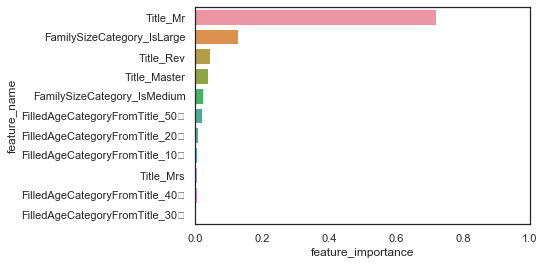

In [72]:
visualize_feature_importance(grid.best_estimator_, X_train)

# SubmitData

In [73]:
X_test = pd.get_dummies(test, drop_first=True)

X_test.head()

,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Others,Title_Rev,FilledAgeCategoryFromTitle_10代,FilledAgeCategoryFromTitle_20代,FilledAgeCategoryFromTitle_30代,FilledAgeCategoryFromTitle_40代,FilledAgeCategoryFromTitle_50代,FilledAgeCategoryFromTitle_60代以上,FamilySizeCategory_IsLarge,FamilySizeCategory_IsMedium
0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,1,0,0,0,1
2,0,0,1,0,0,0,0,0,0,0,0,1,0,0
3,0,0,1,0,0,0,0,1,0,0,0,0,0,0
4,0,0,0,1,0,0,0,1,0,0,0,0,0,1


In [74]:
submit_data = pd.read_csv('../input_data/test.csv', usecols=['PassengerId'])
submit_data['Survived'] = grid.predict(X_test)

# スコア: 0.73684 -> 0.77033 -> 0.78468 <== CVスコアとの乖離は小さい！
submit_data.to_csv('tree_model_FilledAgeCategory_Title_FamilySize_GridSearch.csv', index=False)

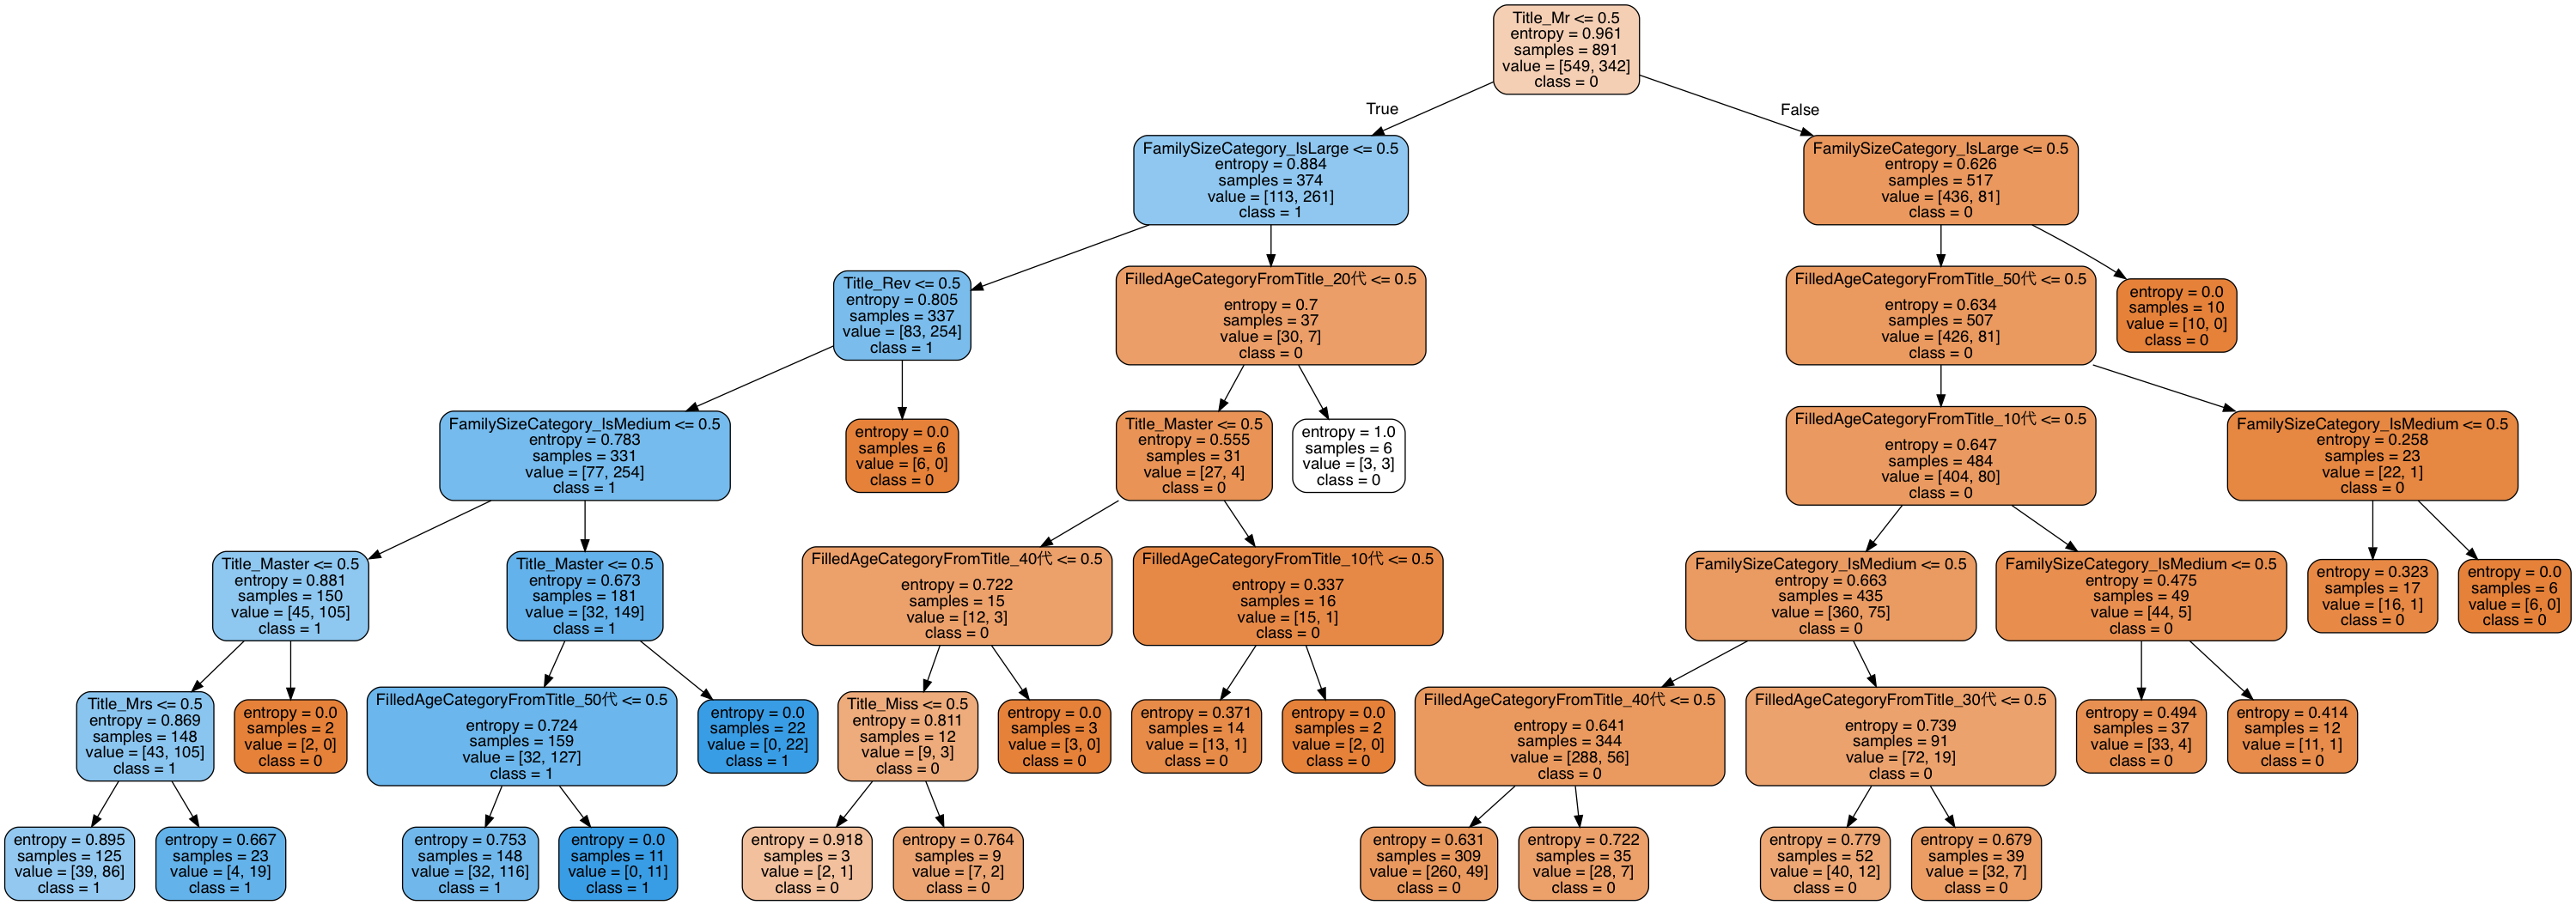

In [66]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

from sklearn.externals.six import StringIO

import pydotplus
from IPython.display import Image

export_graphviz(grid.best_estimator_, 
                out_file='tree.dot',
                feature_names=X_train.columns,
                class_names=["0", "1"],
                filled=True,
                rounded=True)
g = pydotplus.graph_from_dot_file(path='tree.dot')

Image(g.create_png())